<a href="https://colab.research.google.com/github/lazarosgogos/ML-exercises/blob/main/ML_Project_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libraries

In [12]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

# Dataset
The dataset can be found in Kaggle, [here](https://www.kaggle.com/datasets/adityakadiwal/water-potability). It contains ~3K samples of water measurements.

# Q1 - Load and visualise data

In [13]:
df = pd.read_csv('water_potability.csv')
df.describe()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,2785.000000,3276.000000,3276.000000,3276.000000,2495.000000,3276.000000,3276.000000,3114.000000,3276.000000,3276.000000
mean,7.080795,196.369496,22014.092526,7.122277,333.775777,426.205111,14.284970,66.396293,3.966786,0.390110
std,1.594320,32.879761,8768.570828,1.583085,41.416840,80.824064,3.308162,16.175008,0.780382,0.487849
min,0.000000,47.432000,320.942611,0.352000,129.000000,181.483754,2.200000,0.738000,1.450000,0.000000
25%,6.093092,176.850538,15666.690297,6.127421,307.699498,365.734414,12.065801,55.844536,3.439711,0.000000
50%,7.036752,196.967627,20927.833607,7.130299,333.073546,421.884968,14.218338,66.622485,3.955028,0.000000
75%,8.062066,216.667456,27332.762127,8.114887,359.950170,481.792304,16.557652,77.337473,4.500320,1.000000
max,14.000000,323.124000,61227.196008,13.127000,481.030642,753.342620,28.300000,124.000000,6.739000,1.000000


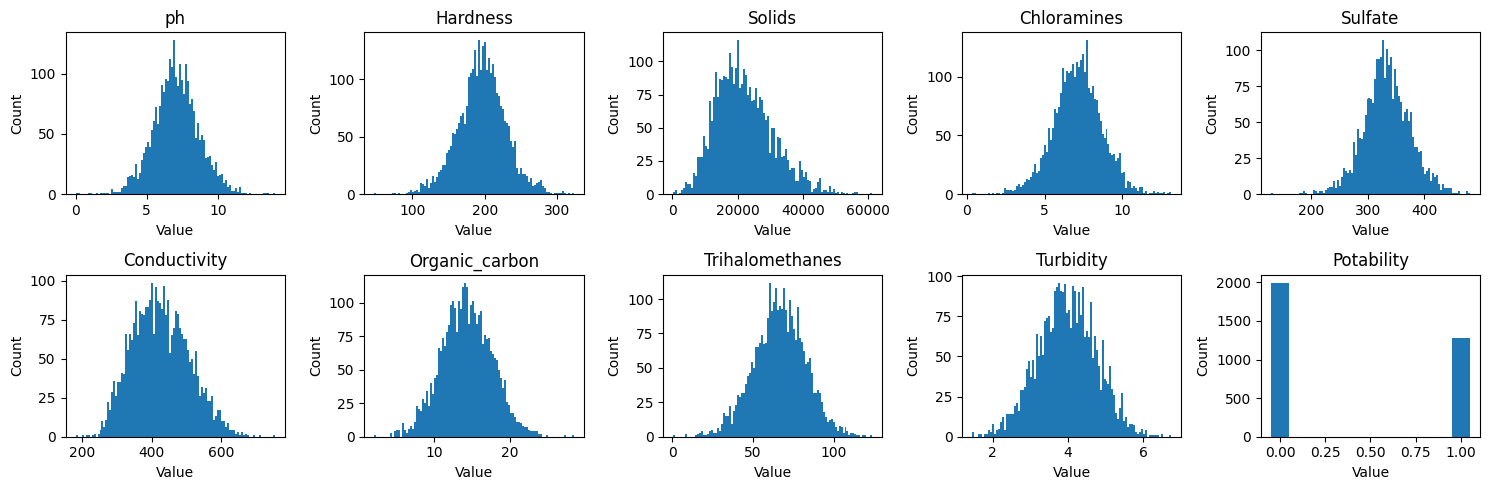

In [14]:
cols = df.columns
plt.figure(1, figsize=(15,5))
for i, col in enumerate(cols):
  plt.subplot(2,5,i+1)
  if col != cols[-1]:
    plt.hist(df[col], bins=100, )
  else:
    plt.bar([0,1], df[col].value_counts(), width=.1)
  plt.title(col)
  plt.xlabel('Value')
  plt.ylabel('Count')
plt.tight_layout()

Count missing values per feature and sample percentage based on water potability.

In [15]:
print('Missing values per feature')
for col in cols:
  s = df[col].isna().sum()
  print(f'  {col:18s}: {s:6}')
pot_df = df[cols[-1]].value_counts()
potable_sum = pot_df[0]
non_potable_sum = pot_df[1]
total = len(df[cols[-1]])
print(f'Potable samples     : {potable_sum/total*100:.2f}%\nNon potable samples : {non_potable_sum/total*100:.2f}%')

Missing values per feature
  ph                :    491
  Hardness          :      0
  Solids            :      0
  Chloramines       :      0
  Sulfate           :    781
  Conductivity      :      0
  Organic_carbon    :      0
  Trihalomethanes   :    162
  Turbidity         :      0
  Potability        :      0
Potable samples     : 60.99%
Non potable samples : 39.01%


# Q2 - Examine  potable sample percentage based on pH value

In [16]:
ph_values = [(0, 6.5), (6.5, 8.5), (8.5, 14)] # (min,max) per tuple
print('Potability percentages based on pH value:')
for ph in ph_values:
  low, high = ph # unpack
  ph_df = df[(df['ph'] >= low) & (df['ph'] < high)]
  potable_counts = ph_df['Potability'].value_counts()
  zeros, ones = potable_counts
  total = len(ph_df)
  print(f'  When the pH value is in [{low}, {high}): \n\
    Non-potable samples : {zeros/total*100:.2f}%\n\
    Potable samples     : {ones/total*100:.2f}%')

Potability percentages based on pH value:
  When the pH value is in [0, 6.5): 
    Non-potable samples : 63.22%
    Potable samples     : 36.78%
  When the pH value is in [6.5, 8.5): 
    Non-potable samples : 56.10%
    Potable samples     : 43.90%
  When the pH value is in [8.5, 14): 
    Non-potable samples : 66.87%
    Potable samples     : 33.13%


Based on the results above, truly most of the potable samples are to be found when the water's pH value is in the range [6.5, 8.5]. However, as other factors (feature values) come into play as well, not all samples in that pH range are potable

# Q3 - Chloramine and pH value cross-examination

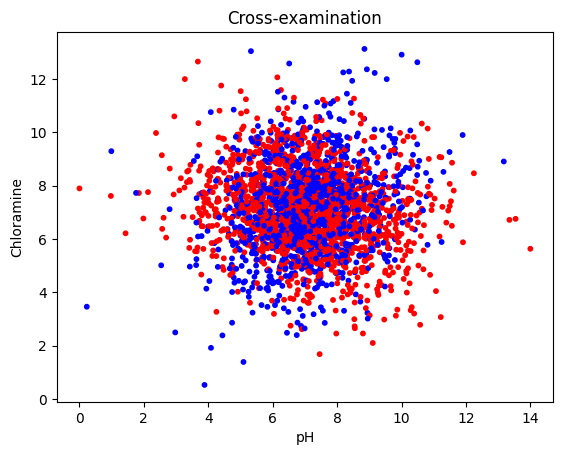

In [17]:
mask = ~df['ph'].isna() # we need to ignore these values
masked_df = df[mask]
ph_df = masked_df['ph']
chlor_df = masked_df['Chloramines']
color = np.where(masked_df['Potability'] == 1, 'blue', 'red')
plt.scatter(ph_df, chlor_df, s=10, c=color)
plt.xlabel('pH')
plt.ylabel('Chloramine')
plt.title('Cross-examination');

As shown in the scatter plot above, the samples cannot be linearly separated based on pH and Chloramine values. We would need another method to separate them.

# Q4 - Fill dataframe missing values

In [18]:
filled_df = df.copy()
for col in cols:
  filled_df[col] = df[col].fillna(df[col].mean())

# Q5 - Create dataset to train tree classifiers

In [19]:
x = np.array(filled_df.drop(columns=['Potability']))
y = np.array(filled_df['Potability'])

seed = 0
test_size = .3

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size,
                                                    random_state=seed)

# Q6 - Train a Decision Tree Classifier

In [20]:
dtree = DecisionTreeClassifier()
dtree.fit(x_train, y_train)

accu_train = dtree.score(x_train, y_train)
accu_test = dtree.score(x_test, y_test)

print(f'Train accuracy : {accu_train*100:6.2f}%\nTest accuracy  : {accu_test*100:6.2f}%')

Train accuracy : 100.00%
Test accuracy  :  58.19%


# Q7 - Try different combinations of options for the DTree

In [21]:
options = {'criterion': ('gini', 'entropy'), 'max_depth': (None, 3, 5),
           'min_samples_split': (2,5), 'min_samples_leaf': (1,2),
           'max_features': (None, 'sqrt'), 'ccp_alpha': (0, 0.01)}

results = []
grid_cols = [*options.keys()]
grid_cols.extend(['train_accuracy', 'test_accuracy'])
grid_df = pd.DataFrame(columns=grid_cols)
for criterion in options['criterion']:
  for max_depth in options['max_depth']:
    for min_samples_split in options['min_samples_split']:
      for min_samples_leaf in options['min_samples_leaf']:
        for max_features in options['max_features']:
          for ccp_alpha in options['ccp_alpha']:
            tree = DecisionTreeClassifier(criterion=criterion,
                                          max_depth=max_depth,
                                          min_samples_split=min_samples_split,
                                          min_samples_leaf=min_samples_leaf,
                                          max_features=max_features,
                                          ccp_alpha=ccp_alpha)
            tree.fit(x_train, y_train)
            tree_accu_train = tree.score(x_train, y_train)
            tree_accu_test = tree.score(x_test, y_test)
            results.append((criterion, max_depth,min_samples_split,
                            min_samples_leaf, max_features, ccp_alpha,
                            tree_accu_train, tree_accu_test))
grid_df = pd.DataFrame(results, columns=grid_cols)
grid_df

,criterion,max_depth,min_samples_split,min_samples_leaf,max_features,ccp_alpha,train_accuracy,test_accuracy
0,gini,NaN,2,1,None,0.00,1.000000,0.569685
1,gini,NaN,2,1,None,0.01,0.605321,0.620549
2,gini,NaN,2,1,sqrt,0.00,1.000000,0.599186
3,gini,NaN,2,1,sqrt,0.01,0.605321,0.620549
4,gini,NaN,2,2,None,0.00,0.952900,0.571719
...,...,...,...,...,...,...,...,...
91,entropy,5.0,5,1,sqrt,0.01,0.605321,0.620549
92,entropy,5.0,5,2,None,0.00,0.671173,0.656155
93,entropy,5.0,5,2,None,0.01,0.620148,0.626653
94,entropy,5.0,5,2,sqrt,0.00,0.642390,0.628688


# Q8 - Select best model when max_depth = 3

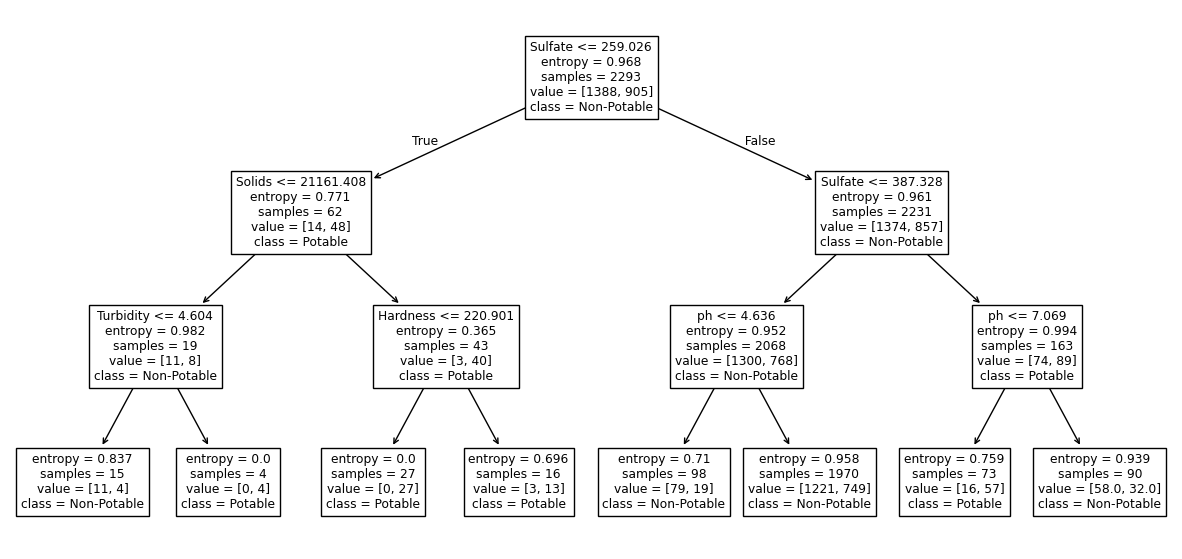

In [22]:
max_depth_3_df = grid_df[grid_df['max_depth'] == 3].reset_index()
idx = max_depth_3_df['test_accuracy'].idxmax()
idx = int(idx)
row = max_depth_3_df.iloc[[idx]]
# drop unnecessary columns
config = row.drop(columns=['index', 'train_accuracy', 'test_accuracy'])
config = config.to_dict(orient='list') # get a dict
config['max_depth'] = [3] # replace 3.0 (float) with 3 (int)
# convert {k: [v]} to {k: v}
for k,v in config.items():
  config[k] = v[0]

custom_tree = DecisionTreeClassifier(**config)
custom_tree.fit(x_train, y_train)
plt.figure(3, figsize=(15,7))
plot_tree(custom_tree, feature_names=cols[:-1], class_names=['Non-Potable', 'Potable']);

Having plotted the tree, we can see how it tries to split the problem into subproblems. Initially, the classifier creates a root split based on Sulfate levels. If the amount of sulfate is less than 260, it checks for the Solids, otherwise it checks for Sulfate levels again. This is based on the objective of maximizing the information gain per split, utilizing the entropy of each split. The process continues recursively until a maximum depth of 3 is hit, where the water is classified based on Sulfate levels initially, then Solids, and then either the pH value or its Hardness (depending on which path the sample takes). Thus, classification is achieved.

# Q9 - Feature importance

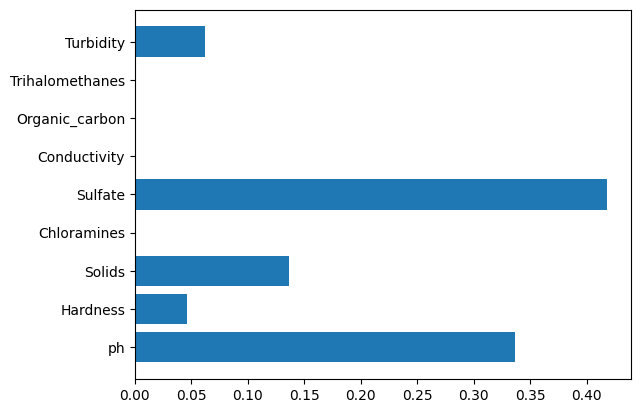

In [23]:
plt.barh(cols[:-1], custom_tree.feature_importances_);

If a device only supported analysis for 5 chemical substances at most, it should focus on the following: [Sulfate, pH, Solids, Turbidity, Hardness].

# Q10 - In favor of Random Forests

Had we used a Random Forest instead of a Decision Tree, we would be able to take advantage of its ability to produce many different trees and get more robust results using the voting procedure that takes place.

# Q11 - Using a Random Forest

In [24]:
n_estimators_options = [50, 100, 200]
for n_estimators in n_estimators_options:
  rf = RandomForestClassifier(n_estimators, random_state=seed)
  rf.fit(x_train, y_train)
  rf_accu_train = rf.score(x_train, y_train)*100
  rf_accu_test  = rf.score(x_test, y_test)*100
  print(f'Number of estimators: {n_estimators}')
  print(f'  Train accuracy : {rf_accu_train:6.2f}%')
  print(f'  Test accuracy  : {rf_accu_test:6.2f}%')

Number of estimators: 50
  Train accuracy : 100.00%
  Test accuracy  :  69.38%
Number of estimators: 100
  Train accuracy : 100.00%
  Test accuracy  :  69.79%
Number of estimators: 200
  Train accuracy : 100.00%
  Test accuracy  :  68.97%


As shown in the results above, a Random Forest can achieve almost 70% accuracy, whereas a Decision Tree could not exceed 63% in accuracy, no matter what combination of hyperparameters is used (out of the ones that were evaluated in Q7). Therefore, a Random Forest proves to be superior.

# Q12 - Bias towards Precision or Recall?

Considering the application of such a classifier, it would be preferable to have a more robust and accurate classifier, which tends to predict with high Precision, rather than high Recall. This allows the user of this classifier to label new water samples more safely.

# Q13 - Decision Tree or Random Forest, legally?

From a legal perspective, it is more preferable to use a Decision Tree. That is mainly due to its easier explainability, in contrast to a Random Forest, which utilizes many classifiers and the prediction is eventually the majority vote of these classifiers. This added complexity makes the Decision Tree a rather preferred option.